# Grey Box Model

This model will be built in Keras. It implements the MYEGA equation that links viscosity to temperature.

Pressure is entered as an input of the neural network, as the compositional features.

In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023
# see embedded licence file
# iVisc 1.0

#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility

import time, os

# local imports
import src.utils as utils
import src.ivisc as ivisc

# deep learning libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import tensorflow as tf
#import torch

# import sklearn utils
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler

import joblib

/tmp/ipykernel_91072/278426627.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # manipulate dataframes
2024-03-12 16:21:17.100150: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 16:21:17.504739: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been reg

## Data loading

In [2]:
# Data loading
print("Loading the viscosity datasets...")
ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5')
print("Loaded.")

# we scale the data here
scaler = StandardScaler().fit(ds.PX_train)
ds.PX_train_scaled = scaler.transform(ds.PX_train)
ds.PX_valid_scaled = scaler.transform(ds.PX_valid)
ds.PX_test_scaled = scaler.transform(ds.PX_test)

Loading the viscosity datasets...
Loaded.


## Greybox model

The greybox model takes in input compositional features and pressure. Temperature viscosity relationship is embedded via the use of the MYEGA equation.

The code for the greybox model is available in `src/ivisc.py`

404/404 [==============================] - 0s 385us/step


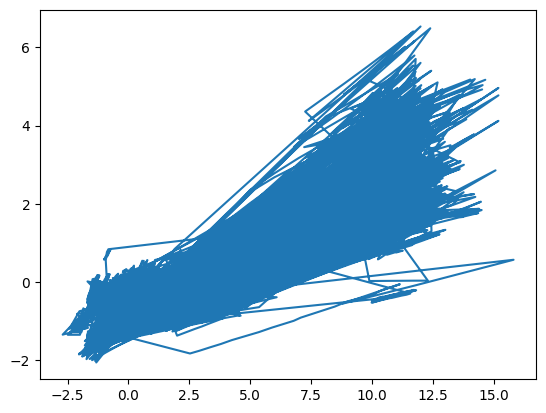

In [14]:
input_shape = ds.PX_train_scaled.shape[1:]

def build_model(hp):

    num_layer = hp.Int("num_layer", min_value=1, max_value=6, step=1)
    layers = []
    for i in range(num_layer):
        layers.append(hp.Int("num_"+str(i), min_value=20, max_value=700, step=50))
    
    model, myega_layer = ivisc.build_greybox_1(
    input_shape,
    mlp_units=layers,
    mlp_dropout=hp.Float("mlp_dropout", min_value=0.05, max_value=0.5, step=0.05),
    activation=hp.Choice("activation", ["swish", "gelu"])
    )
    
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mse"],
    )
    return model

import keras_tuner

model = build_model(keras_tuner.HyperParameters())

y_pred_start = model.predict((ds.PX_train_scaled, ds.T_train))

# We check some first predictions
plt.plot(ds.y_train, y_pred_start)

In [15]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_mse",
    max_trials=20,
    num_initial_points=5,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layer (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
num_0 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 700, 'step': 50, 'sampling': 'linear'}
mlp_dropout (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
activation (Choice)
{'default': 'swish', 'conditions': [], 'values': ['swish', 'gelu'], 'ordered': False}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [16]:
tuner.search((ds.PX_train_scaled, ds.T_train), ds.y_train, 
             epochs=10, 
             validation_data=((ds.PX_valid_scaled, ds.T_valid), ds.y_valid))


Trial 20 Complete [00h 00m 09s]
val_mse: 0.49923175573349

Best val_mse So Far: 0.2931775748729706
Total elapsed time: 00h 02m 48s


In [17]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 156)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 120)                  18840     ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 120)                  0         ['dense[0][0]']               
                                                                                                  
 dropout (Dropout)           (None, 120)                  0         ['activation[0][0]']          
                                                                                              

In [28]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])

#def scheduler(epoch, lr):
#    if epoch < 20:
#        return 0.001
#    else:
#        return 0.0001


callbacks = [keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True),]
            #keras.callbacks.LearningRateScheduler(scheduler)]

history = model.fit(
    (ds.PX_train_scaled,ds.T_train),
    ds.y_train.ravel(),
    validation_data=([ds.PX_valid_scaled,ds.T_valid],ds.y_valid.ravel()),
    epochs=1000,
    batch_size=1024,
    callbacks=callbacks,
)

#model.evaluate(x_test, y_test, verbose=1)


Epoch 1/1000
13/13 [==============================] - 1s 11ms/step - loss: 24.1041 - mse: 24.1041 - val_loss: 20.0268 - val_mse: 20.0268
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 15.3651 - mse: 15.3651 - val_loss: 10.2090 - val_mse: 10.2090
Epoch 3/1000
13/13 [==============================] - 0s 3ms/step - loss: 8.5927 - mse: 8.5927 - val_loss: 5.5283 - val_mse: 5.5283
Epoch 4/1000
13/13 [==============================] - 0s 3ms/step - loss: 5.3447 - mse: 5.3447 - val_loss: 4.3011 - val_mse: 4.3011
Epoch 5/1000
13/13 [==============================] - 0s 3ms/step - loss: 4.4457 - mse: 4.4457 - val_loss: 3.6733 - val_mse: 3.6733
Epoch 6/1000
13/13 [==============================] - 0s 3ms/step - loss: 3.9241 - mse: 3.9241 - val_loss: 3.2307 - val_mse: 3.2307
Epoch 7/1000
13/13 [==============================] - 0s 3ms/step - loss: 3.4453 - mse: 3.4453 - val_loss: 2.7886 - val_mse: 2.7886
Epoch 8/1000
13/13 [==============================] - 0s 3ms/step -

In [8]:
# After training, get the value of 'ae'
ae_value_after_training = K.get_value(myega_layer.ae)
print("Value of ae after training:", ae_value_after_training)

NameError: name 'myega_layer' is not defined

In [29]:
print("Saving model...")
model.save('models/model1_best.keras')



Saving model...


In [30]:
for i,layer in enumerate(model.layers):
    if hasattr(layer, "activation"):
        print(layer.name, layer.activation)
    else:
        print(layer.name, 'None')

input_5 None
dense_11 <function linear at 0x7e11130d5e40>
activation_11 <function swish at 0x7e11130d5120>
dropout_11 None
dense_12 <function linear at 0x7e11130d5e40>
activation_12 <function swish at 0x7e11130d5120>
dropout_12 None
dense_13 <function linear at 0x7e11130d5e40>
activation_13 <function swish at 0x7e11130d5120>
dropout_13 None
dense_14 <function linear at 0x7e11130d5e40>
activation_14 <function swish at 0x7e11130d5120>
dropout_14 None
dense_15 <function linear at 0x7e11130d5e40>
activation_15 <function swish at 0x7e11130d5120>
dropout_15 None
Tg <function linear at 0x7e11130d5e40>
frag <function linear at 0x7e11130d5e40>
input_6 None
tf.math.exp_4 None
tf.math.exp_5 None
myega_calculation_layer_model1_2 None


In [31]:
model = keras.models.load_model('models/model1_best.keras', 
                                custom_objects={'MyegaCalculationLayer_model1': ivisc.MyegaCalculationLayer_model1})

y_pred_train = model.predict((ds.PX_train_scaled, ds.T_train))
y_pred_valid = model.predict((ds.PX_valid_scaled, ds.T_valid))
y_pred_test = model.predict((ds.PX_test_scaled, ds.T_test))



44/44 [==============================] - 0s 422us/step


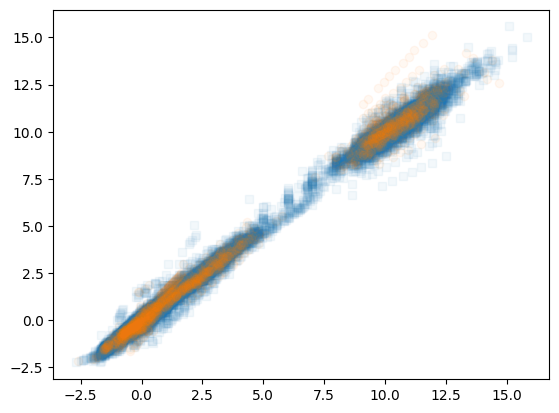

In [32]:
plt.plot(ds.y_train, y_pred_train,"s",alpha=0.05)
plt.plot(ds.y_valid, y_pred_valid,"o",alpha=0.05)


In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error, r2_score

MSE_visco_train = mean_squared_error(y_pred_train, ds.y_train,squared=False)
MSE_visco_valid = mean_squared_error(y_pred_valid, ds.y_valid,squared=False)
MSE_visco_test = mean_squared_error(y_pred_test, ds.y_test,squared=False)

MAE_visco_train = median_absolute_error(y_pred_train, ds.y_train)
MAE_visco_valid = median_absolute_error(y_pred_valid, ds.y_valid)
MAE_visco_test = median_absolute_error(y_pred_test, ds.y_test)

R2_visco_train = r2_score(y_pred_train, ds.y_train)
R2_visco_valid = r2_score(y_pred_valid, ds.y_valid)
R2_visco_test = r2_score(y_pred_test, ds.y_test)

print("Viscosity\n      train, valid, test \nRMSE : {:.2f}, {:.2f}, {:.2f}".format(MSE_visco_train,MSE_visco_valid,MSE_visco_test))
print("MAE :  {:.2f}, {:.2f}, {:.2f}".format(MAE_visco_train,MAE_visco_valid,MAE_visco_test))
print("R2 :  {:.3f}, {:.3f}, {:.3f}".format(R2_visco_train,R2_visco_valid,R2_visco_test))

Viscosity
      train, valid, test 
RMSE : 0.38, 0.50, 0.46
MAE :  0.17, 0.19, 0.20
R2 :  0.994, 0.989, 0.991


/home/charles/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/charles/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/charles/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer("Tg").output)

In [25]:
intermediate_output = intermediate_layer_model((ds.PX_train_scaled, ds.T_train))

In [26]:
np.median(intermediate_output.numpy())

6.8953104

(array([ 238.,  343.,  867., 1105.,  902., 2559., 4865., 1826.,  114.,
          83.]),
 array([6.2983284 , 6.39481974, 6.49131107, 6.58780289, 6.68429422,
        6.78078556, 6.8772769 , 6.97376823, 7.07026005, 7.16675138,
        7.26324272]),
 <BarContainer object of 10 artists>)

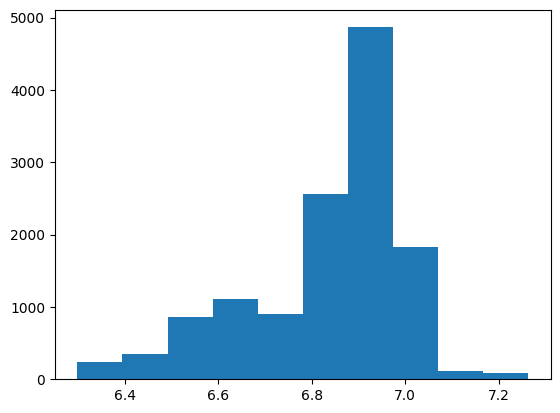

In [27]:
plt.hist(intermediate_output.numpy())

# Prediction for one composition

We compare the blackbox models for the prediction of the viscosity of a given composition

In [90]:
# initial data import
di_ = dataset_lp.loc[dataset_lp.Name_publi=="NAK75_12_0",:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(900, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_xgb = clf_xgb.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))


plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Data")
plt.plot(1/T_interest, oneC_nn,"x",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_xgb,".", label="XGBoost")
plt.plot(1/T_interest, oneC_grey+6.25,"-", label="Greybox ANN")
plt.legend(loc='best')
#plt.ylim(-5,4)
#plt.xlim(0.00025,0.001)

NameError: name 'clf_nn' is not defined

# Comparison with a transformer network

In [31]:
# with reshaping for proper entrance into Transformer
X_train_Ptrans = np.expand_dims(X_train_sP, axis=2)
X_valid_Ptrans = np.expand_dims(X_valid_sP, axis=2)
X_test_Ptrans = np.expand_dims(X_test_sP, axis=2)

input_shape = X_train_Ptrans.shape[1:]

model = build_model(
    input_shape,
    head_size=400,
    num_heads=3,
    ff_dim=6,
    num_transformer_blocks=6,
    mlp_units=[400],
    mlp_dropout=0.2,
    dropout=0.2,
)

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mse"],
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 156, 1)]             0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 156, 1)               8401      ['input_3[0][0]',             
 iHeadAttention)                                                     'input_3[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, 156, 1)               0         ['multi_head_attention[0][0]']
                                                                                                  
 layer_normalization (Layer  (None, 156, 1)               2         ['dropout_4[0][0]']     

368/368 [==============================] - 271s 734ms/step


ValueError: x and y must have same first dimension, but have shapes (11767, 1) and (2, 11767, 1)

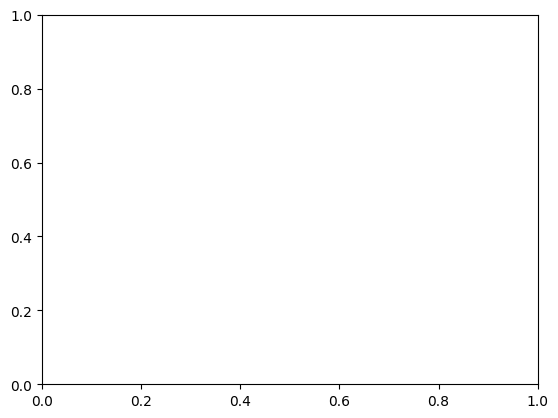

In [32]:
y_pred_start2 = model.predict((X_train_Ptrans, T_train))

plt.plot(y_train, y_pred_start2)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]

model.fit(
    (X_train_Ptrans,T_train),
    y_train.ravel(),
    validation_data=([X_valid_Ptrans,T_valid],y_valid),
    epochs=4000,
    batch_size=128,
    callbacks=callbacks,
)

#model.evaluate(x_test, y_test, verbose=1)


In [ ]:
y_pred_2 = model.predict((X_train_Ptrans, T_train))

plt.plot(y_train, y_pred_2)

In [ ]:
model.

In [ ]:
# initialize weights of the last layer
torch.nn.init.normal_(neuralmodel.out_thermo.weight, mean=0, std=0.001)
y_pred_notrain = neuralmodel.ag(torch.FloatTensor(ds.x_visco_train).to(device),
                                torch.FloatTensor(ds.T_visco_train).to(device),
                                torch.FloatTensor(ds.P_visco_train).to(device))
plt.plot(ds.T_visco_train, y_pred_notrain.cpu().detach().numpy())

In [ ]:
#
# TRAINING
#
time1 = time.time()
optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.0001) # optimizer
neuralmodel, record_train_loss, record_valid_loss = training(neuralmodel,ds,
                                                                   criterion,optimizer,
                                                                   save_switch=True,save_name=name,
                                                                   train_patience=400,min_delta=0.05,
                                                                   verbose=True, device=device)

time2 = time.time()
print("It took {:.1f} seconds".format(time2-time1))
print(name)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(record_train_loss,label="train")
plt.plot(record_valid_loss,label="valid")
plt.legend()
# with zoom after 600 epochs
plt.subplot(2,1,2)
plt.plot(record_train_loss,label="train")
plt.plot(record_valid_loss,label="valid")
plt.xlim(600,)
plt.ylim(-10,10)
plt.legend()
plt.savefig("./figures/single/deepmelt_loss.pdf")

In [ ]:
#
# Print a metric to see performance
#

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

MSE_visco_train = mean_squared_error(neuralmodel.ag(ds.x_visco_train.to(device),
                                                    ds.T_visco_train.to(device),
                                                    ds.P_visco_train.to(device)).cpu().detach().numpy(),
                                     ds.y_visco_train,squared=False)
MSE_visco_valid = mean_squared_error(neuralmodel.ag(ds.x_visco_valid.to(device),
                                                    ds.T_visco_valid.to(device),
                                                    ds.P_visco_valid.to(device)).cpu().detach().numpy(),
                                     ds.y_visco_valid,squared=False)
MSE_visco_test = mean_squared_error(neuralmodel.ag(ds.x_visco_test.to(device),
                                                   ds.T_visco_test.to(device),
                                                   ds.P_visco_test.to(device)).cpu().detach().numpy(),
                                    ds.y_visco_test,squared=False)

MAE_visco_train = median_absolute_error(neuralmodel.ag(ds.x_visco_train.to(device),
                                                       ds.T_visco_train.to(device),
                                                       ds.P_visco_train.to(device)).cpu().detach().numpy(),
                                        ds.y_visco_train)
MAE_visco_valid = median_absolute_error(neuralmodel.ag(ds.x_visco_valid.to(device),
                                                       ds.T_visco_valid.to(device),
                                                       ds.P_visco_valid.to(device)).cpu().detach().numpy(),
                                        ds.y_visco_valid)
MAE_visco_test = median_absolute_error(neuralmodel.ag(ds.x_visco_test.to(device),
                                                      ds.T_visco_test.to(device),
                                                      ds.P_visco_test.to(device)).cpu().detach().numpy(),
                                       ds.y_visco_test)


print("Viscosity\n      train, valid, test \nRMSE : {:.2f}, {:.2f}, {:.2f}".format(MSE_visco_train,MSE_visco_valid,MSE_visco_test))
print("MAE :  {:.2f}, {:.2f}, {:.2f}".format(MAE_visco_train,MAE_visco_valid,MAE_visco_test))

In [ ]:

Ae_rec = neuralmodel.ae(ds.x_visco_test.to(device)).cpu().detach().numpy()
plt.hist(Ae_rec)


In [ ]:
y_pred_trained = neuralmodel.ag(torch.FloatTensor(ds.x_visco_train).to(device), torch.FloatTensor(ds.T_visco_train).to(device))

In [ ]:
plt.plot(ds.y_visco_train, y_pred_trained.cpu().detach().numpy(),".")
plt.xscale(-2.5,15)
plt.yscale(-2.5,15)

In [ ]:
# evaluate a model trained away

# make sure that the architecture is the same as in the trained model
nb_layers = 4
nb_neurons = 400
p_drop = 0.15

# constructing name
name = "./model/l"+str(nb_layers)+"_n"+str(nb_neurons)+"_p"+str(p_drop)+"_DEEPMELT"+".pth"
#name = "./model/ray_model/checkpoint.pt"

# loading model
neuralmodel = imelt.model(ds.x_visco_train.shape[1],nb_neurons,nb_layers,ds.nb_channels_raman,
                          p_drop=p_drop, activation_function = torch.nn.GELU())

#model_state, optimizer_state = torch.load(name, map_location=torch.device(device))
#neuralmodel.load_state_dict(model_state)

neuralmodel.load_state_dict(torch.load(name, map_location=device))
neuralmodel.to(device)
neuralmodel.eval()

#
# Print a metric to see performance
#

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

MSE_visco_train = mean_squared_error(neuralmodel.viscosity_fuse(ds.x_visco_train.to(device),ds.T_visco_train.to(device)).cpu().detach().numpy(), ds.y_visco_train,squared=False)
MSE_visco_valid = mean_squared_error(neuralmodel.viscosity_fuse(ds.x_visco_valid.to(device),ds.T_visco_valid.to(device)).cpu().detach().numpy(), ds.y_visco_valid,squared=False)
MSE_visco_test = mean_squared_error(neuralmodel.viscosity_fuse(ds.x_visco_test.to(device),ds.T_visco_test.to(device)).cpu().detach().numpy(), ds.y_visco_test,squared=False)

MAE_visco_train = median_absolute_error(neuralmodel.viscosity_fuse(ds.x_visco_train.to(device),ds.T_visco_train.to(device)).cpu().detach().numpy(), ds.y_visco_train)
MAE_visco_valid = median_absolute_error(neuralmodel.viscosity_fuse(ds.x_visco_valid.to(device),ds.T_visco_valid.to(device)).cpu().detach().numpy(), ds.y_visco_valid)
MAE_visco_test = median_absolute_error(neuralmodel.viscosity_fuse(ds.x_visco_test.to(device),ds.T_visco_test.to(device)).cpu().detach().numpy(), ds.y_visco_test)

print("Viscosity\n      train, valid, test \nRMSE : {:.2f}, {:.2f}, {:.2f}".format(MSE_visco_train,MSE_visco_valid,MSE_visco_test))
print("MAE :  {:.2f}, {:.2f}, {:.2f}".format(MAE_visco_train,MAE_visco_valid,MAE_visco_test))